## Implement homogeneous to inhomogeneous transformation as described in 
## "Spectral Solution with a Subtraction Method to Improve Accuracy"
### Matthew Green
### Santa Clara University

In [45]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

def fDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

def bDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 


def iterativeRefinement(A, b, tolerance = 1e-9): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        #print(f"After {iteration} iterations with residual error {residualError}")
        if iteration > 100:
            break

    #print(f"Finished in {iteration} iterations with residual error {residualError}")
    return C 

def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def cosineDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order, dtype=complex) 
    b[0] = f[ 0]
    b[1] = f[-1]
    for i in range(1, order):
        b[i*2    ] = Dl[2*i-1]/(np.pi)**(2*i) 

    for i in range(1, order): 
        b[i*2 + 1] = Dr[2*i-1]/(np.pi)**(2*i) 

    return b 

def cosineDiffMat(order): 
    A = np.zeros((order*2, order*2), dtype=complex)
    for i in range(order): 
        derivative  = 2 * i 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i 
            #Cosine evaluated at pi gives negative sign depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j 

    return A


def reconstruct(C, x, derivative_order = 0, t = 0):
    f = np.zeros(x.shape, dtype=complex)
    L = x[-1] - x[0]
    xeval = shiftx(x)
    for k in range(1, len(C) + 1):
        f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * (np.exp(1j * (k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2

    return f

def getShiftFunction(f, order, x): 
    xeval = shiftx(x)
    dx = x[1] - x[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    A = cosineDiffMat(int(order/2) + 1) 
    b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
    print("b", b)
    C = iterativeRefinement(A, b)


    shift = reconstruct(C, x)
    return shift, C

def getk(p, dx):
    N = len(p)
    M = 2 * ( N + 1 )
    n = np.arange(1, int(M/2)    )
    k = 2 * np.pi / ( M * dx ) * n
    return k


In [67]:
order = 13 
dx = x[1] - x[0]
g = reconstruct(C, x, 0)

A = fDiffMat (order, dx) 
b = fDiffVec (order, g)
Dl2 = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  g)
Dr2 = iterativeRefinement(A, b)

reconstruct(C, x, 4)[[0, -1]], Dl2[3], Dr2[3]

(array([1.00036269+1.00036269j, 2.7176662 +2.7176662j ]),
 (0.47915023048021615+0.47915023048021615j),
 (2.1774872197319044+2.1774872197319044j))

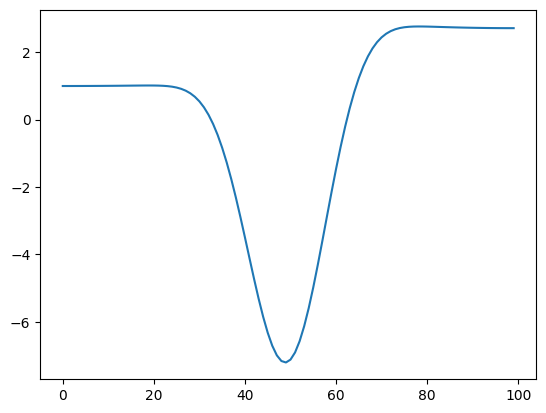

In [69]:
plt.plot(reconstruct(C, x, 0).real)

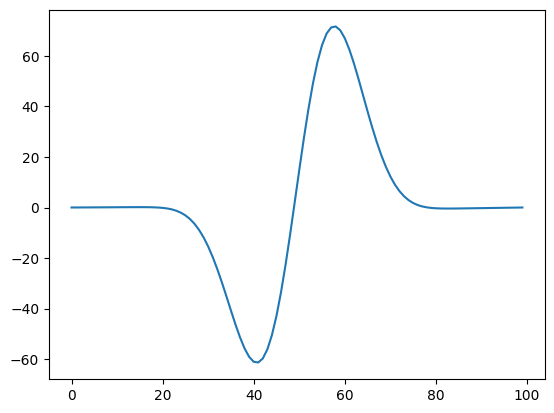

In [71]:
plt.plot(reconstruct(C, x, 1).real)

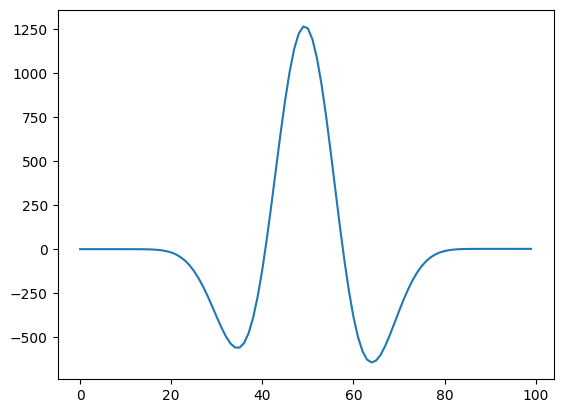

In [70]:
plt.plot(reconstruct(C, x, 2).real)

In [59]:

x = np.linspace(0, 1, 100)
f = np.exp(x) + 1j * np.exp(x)
dx = x[1] - x[0]

order = 13
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)
Dl1 = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)
Dr1 = iterativeRefinement(A, b)

shift, C = getShiftFunction(f, order, x) 
hom = f - shift


A = fDiffMat (order, dx) 
b = fDiffVec (order, hom)
Dl2 = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  hom)
Dr2 = iterativeRefinement(A, b)

for i in range(1, order+1): 
    print(f"Order = {i} LD1: {Dl1[i-1]:3.3e} LD2: {Dl2[i-1]:3.3e}")
    print(f"Order = {i} RD1: {Dr1[i-1]:3.3e} RD2: {Dr2[i-1]:3.3e}")

b [ 1.00000000e+00+1.00000000e+00j  2.71828183e+00+2.71828183e+00j
  1.01321184e-01+1.01321184e-01j  2.75419532e-01+2.75419532e-01j
  1.02697056e-02+1.02697056e-02j  2.78995130e-02+2.78995130e-02j
  1.56343689e-02+1.56343689e-02j -2.12082031e-02-2.12082031e-02j
  2.41244734e+01+2.41244734e+01j -3.84890723e+01-3.84890723e+01j
  1.51010256e+04+1.51010256e+04j -2.33636801e+04-2.33636801e+04j
  2.37893105e+06+2.37893105e+06j -3.57830346e+06-3.57830346e+06j]
Order = 1 LD1: 1.000e+00+1.000e+00j LD2: 1.000e+00+1.000e+00j
Order = 1 RD1: 2.718e+00+2.718e+00j RD2: 2.718e+00+2.718e+00j
Order = 2 LD1: 1.000e+00+1.000e+00j LD2: 4.193e-06+4.193e-06j
Order = 2 RD1: 2.718e+00+2.718e+00j RD2: 4.336e-06+4.336e-06j
Order = 3 LD1: 1.000e+00+1.000e+00j LD2: 9.983e-01+9.983e-01j
Order = 3 RD1: 2.718e+00+2.718e+00j RD2: 2.720e+00+2.720e+00j
Order = 4 LD1: 1.000e+00+1.000e+00j LD2: 5.212e-01+5.212e-01j
Order = 4 RD1: 2.718e+00+2.718e+00j RD2: 5.402e-01+5.402e-01j
Order = 5 LD1: 9.205e-01+9.205e-01j LD2: -1.28

b [ 1.00000000e+00+1.00000000e+00j  2.71828183e+00+2.71828183e+00j
  1.00000000e+00+1.00000000e+00j  2.71828183e+00+2.71828183e+00j
  1.00000774e+00+1.00000774e+00j  2.71825434e+00+2.71825434e+00j
  1.13189923e+00+1.13189923e+00j  2.25698898e+00+2.25698898e+00j
  4.91214864e+02+4.91214864e+02j -1.66585308e+03-1.66585308e+03j]


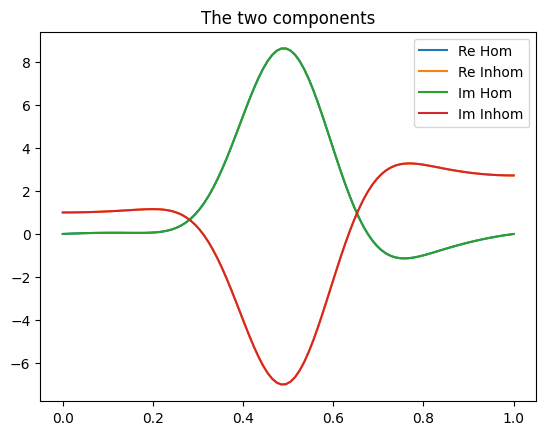

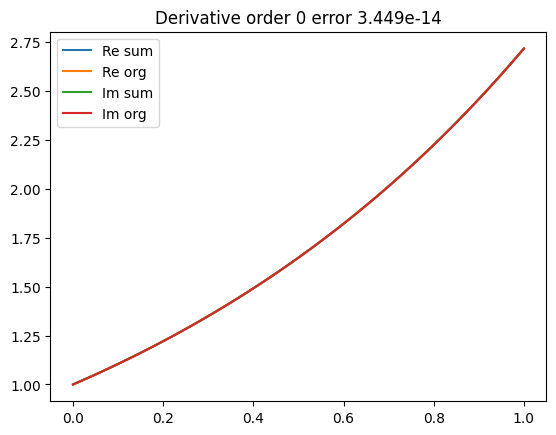

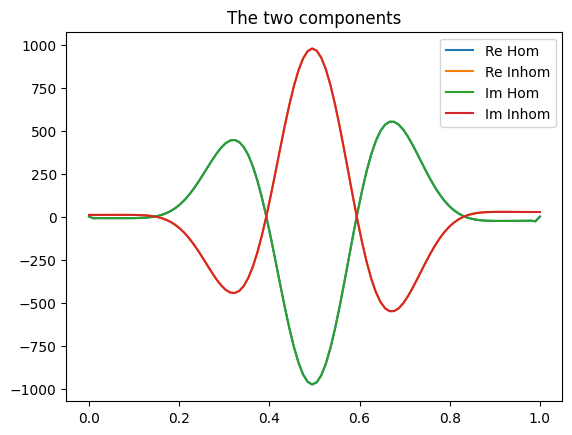

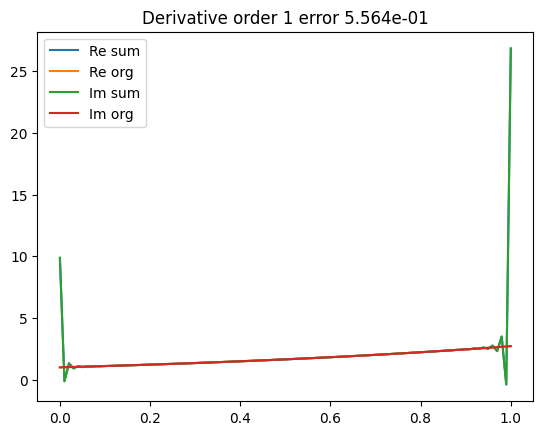

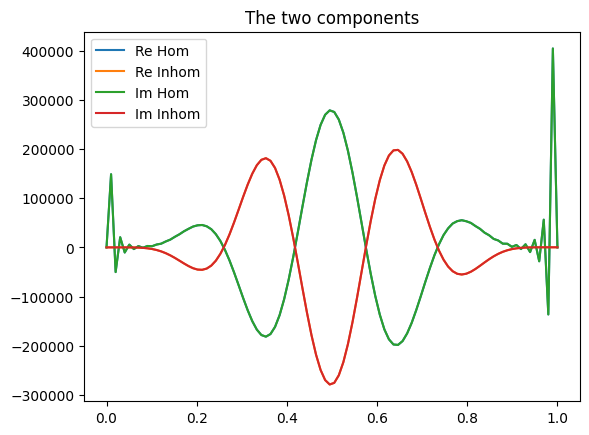

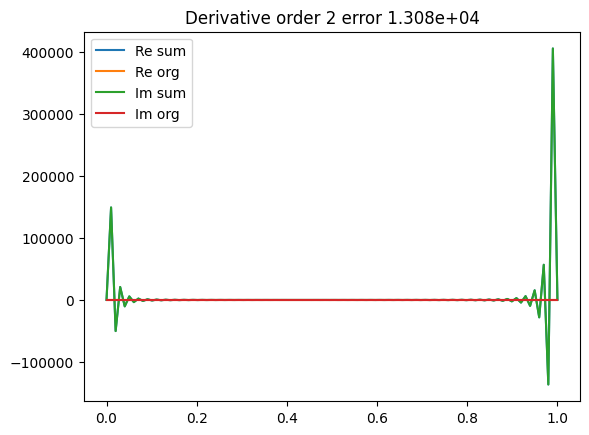

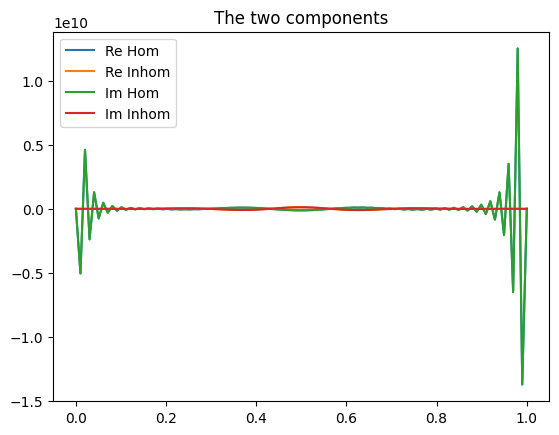

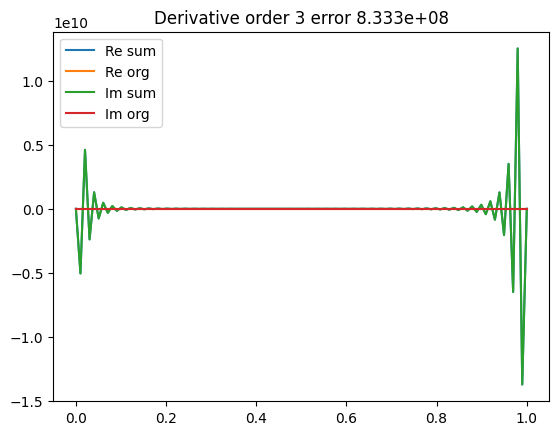

In [44]:

x = np.linspace(0, 1, 100)
f = np.exp(x) + 1j * np.exp(x)
dx = x[1] - x[0]
shift, C = getShiftFunction(f, 9, x) 
hom = f - shift
fhat = scipy.fft.dst(hom[1:-1], type=1) 
k = getk(fhat, dx) 

for i in range(0, 4): 
    forg = np.exp(x) + 1j * np.exp(x)
    fha  = fhat * (-1)**i * (k)**(2*i)
    frec = np.pad(scipy.fft.idst(fha, type=1), (1, 1), mode="constant")
    frec = frec
    reco = reconstruct(C, x, 2 * i)
    sumo = frec + reco 
    if 1:
        plt.title(f"The two components")
        plt.plot(x, frec.real, label="Re Hom") 
        plt.plot(x, reco.real, label="Re Inhom") 
        plt.plot(x, frec.imag, label="Im Hom") 
        plt.plot(x, reco.imag, label="Im Inhom") 
        plt.legend()
        plt.show() 
    plt.title(f"Derivative order {i} error {np.mean(np.abs(sumo-forg)):3.3e}")
    plt.plot(x, sumo.real, label="Re sum") 
    plt.plot(x, forg.real, label="Re org") 
    plt.plot(x, sumo.imag, label="Im sum") 
    plt.plot(x, forg.imag, label="Im org") 
    plt.legend()
    plt.show() 

## Test decay of Fourier coefficients

0.008550008069148296
6.0843401899379757e-05
4.119582211803419e-06
3.9242796553429216e-06
3.923703116637256e-06
3.9237015014848e-06
3.923701417996028e-06


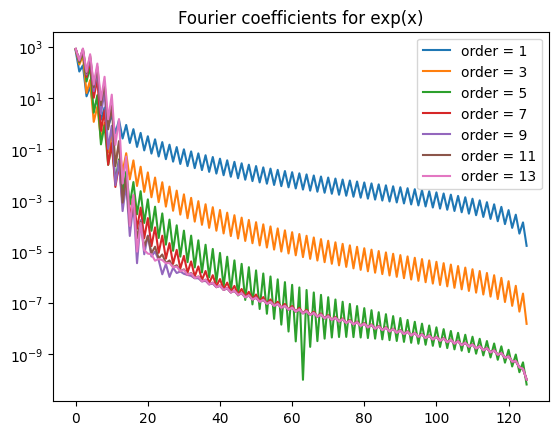

20.189712907576425
0.3745640007486759
0.002159370264478211
0.0005146003497589202
0.0005091647167592139
0.0005091485654975525
0.0005091485106152316


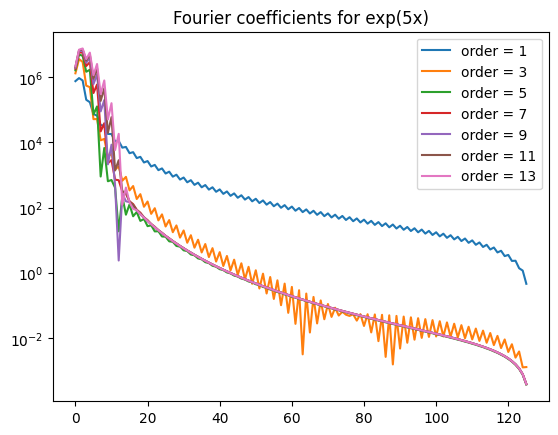

0.0008292271077181279
1.1451971373144243e-06
-3.870708140035761e-06
-3.8872907546158575e-06
-3.887338615282676e-06
-3.887338757259384e-06
-3.8873387875892895e-06


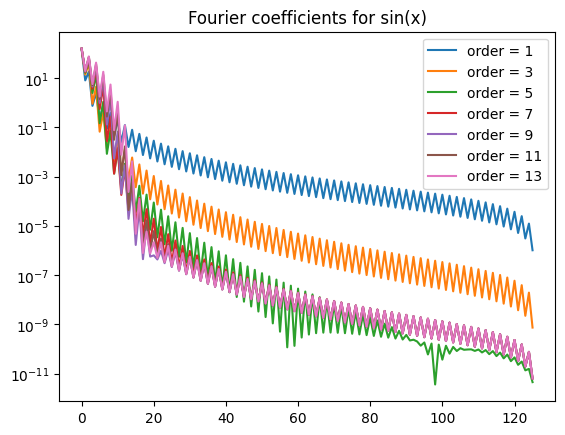

-0.0030448906616483695
-0.0038214965458363004
-0.0038673547543722764
-0.003863315905571041
-0.0038634296711272387
-0.003863426500554823
-0.0038634265838587978


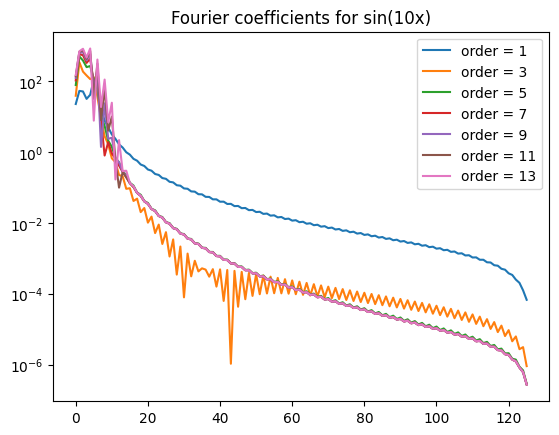

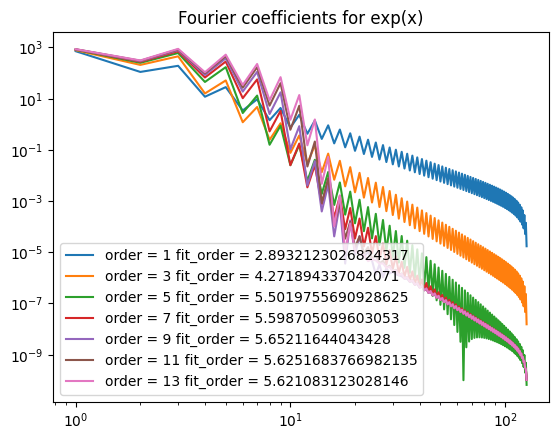

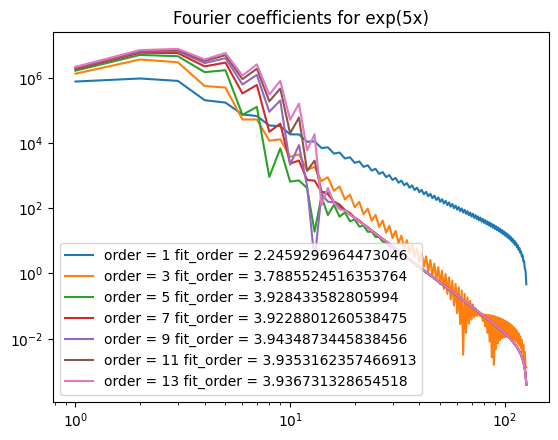

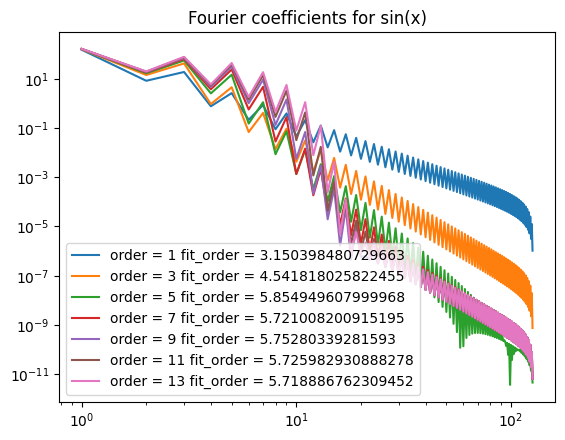

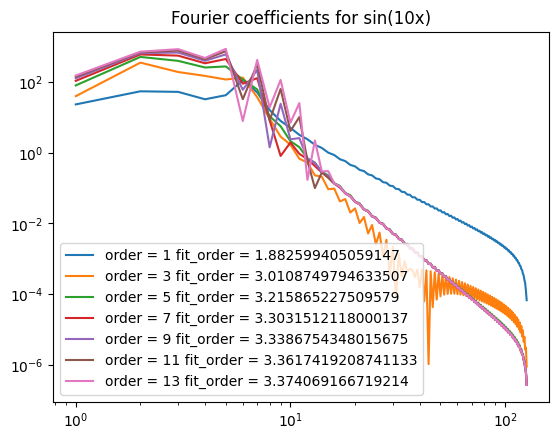

In [20]:
x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    plt.yscale("log") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift 
        print(hom[0] - 2 * hom[1] + hom[2])
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        plt.plot(np.abs(fhat), label=f"order = {order}") 
    plt.legend()
    plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift 
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        y    = np.abs(fhat)
        r    = np.arange(1, len(y)+1)
        #print(len(y), len(r))
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 